# Scripts to plot all best-fit solutions in the paper

In [4]:
# basics
import pandas as pd
import numpy as np

# astronomical units and constants
import astropy.units as u
from astropy.constants import R_sun


# matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib.container import ErrorbarContainer
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# data management
import os
CWD = "/".join(os.getcwd().split("/")[:-2])


# modulation model
from funcs.model import FlareModulator#, full_model_coupled, aflare_decoupled, aflare
from funcs.helper import fetch_lightcurve


# Single flare solution decoupled

In [5]:
# Datasets we analysed, and some tinkering with plotting ranges
datasets = [
#             (452922110, "normal_uncertainty", None, None,
#             "07_12_2020_15_44", ""),
#             (452922110,"high_uncertainties_peak1", None, None,
#             "10_12_2020_07_05", ""),
#             (44984200, "normal_uncertainty", 1587.8,1588.7, 
#             "07_12_2020_18_46", ""),
#             (44984200, "high_uncertainties_peak1", 1587.8,1588.7,
#             "10_12_2020_07_12", "c"), 
            (277539431, "normal_uncertainty", None, None, 
             "07_12_2020_15_26", "")
            ]

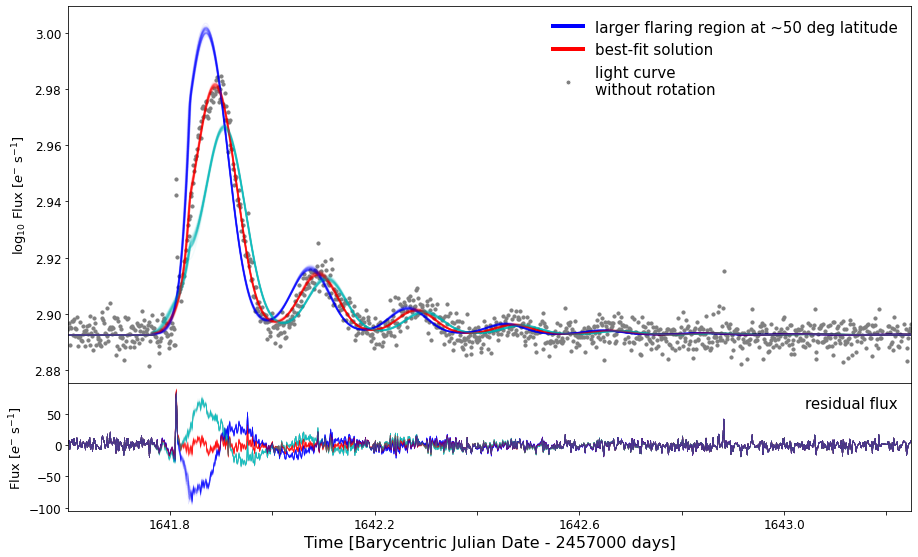

In [6]:
# Pick up stellar parameters
props = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
# Pick up the input parameters
mcmcinit = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")
# number of samples from the posterior distribution
N = 50

for ID, name, start, stop, tstamp, suffix in datasets:

    # Get MCMC data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")

    # pick stellar parameters
    target = props[props.ID == int(ID)].iloc[0]
    
    
    inits = mcmcinit[(mcmcinit.ID.astype(str) == str(ID) + suffix) & (mcmcinit.tstamp==tstamp)].iloc[0]
    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg / u.cm**2 / u.s 
    R = inits.R_Rsun * R_sun

    # pick up light curve
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    median = lc.median_[0]
    
    # figures geometry: three panel of different size
    # from top to bottom: 
    # TOP: light curve and quiescent flux, rotation period
    # CENTER: flare-only light curve, model solution, underlying flare
    # BOTTOM: flare-model residuals, and uncertainties on flux
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13,8),sharex=True)
    divider = make_axes_locatable(ax)

#     ax = divider.append_axes("bottom", size="100%", pad=0)
#     ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax.figure.add_axes(ax2)

    # CENTER: flare-only light curve
    ax.scatter(time, np.log10(flux), s=10, c="grey")
    
    # plot N random solutions from the posterior distribution
    inds = np.random.randint(df.shape[0], size=N)
    for ind in inds:
        for afactor, sigma, color in [(-np.pi/180*30,0, "blue"), (0,0,"r"),(+np.pi/180*30,0, "c"),]:#[(-3.,"c"),(-1.8, "blue"), (0,"r"), (1.5,"blue"),(2.5,"c")]:
        # pick solution from MCMC chain
            sample = df.loc[ind,]

            # get flare parameters
            a = sample.a #* afactor
            Fth = Fth #* afactor
            flaret = 1e4 #* afactor
            phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
            theta_a = (sample.latitude_deg +sigma) / 180 * np.pi 
            fwhm1 = sample.fwhm1_d  / target.Prot_d * 2 * np.pi
            fwhm2 = sample.fwhm2_d / target.Prot_d * 2 * np.pi

            # ... and also the updated inclination
            i = (sample.i_deg) / 180 * np.pi

            # convert flare peak phase to phase at t0
            phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi) + afactor

            # CENTER: plot the underlying best-fit flare
            flareparams =  [[a, phi_a, fwhm1, fwhm2]]
    #         print(flareparams)

            FM = FlareModulator(phi, flux, lc.flux_err.values, qlum, R, median, 1, False,flaret=flaret)

    #         flare = FM.flare_template([a*median, phi_a, fwhm1, fwhm2]) + median
    #         ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)

            # CENTER: plot the modulated best-fit flare
            fullmodel = FM.modulated_flux(theta_a, phi0, i,flareparams)
     #       phi_a, theta_a, a, fwhm1, fwhm2, i, phi0=phi0,
      #                             phi=phi, num_pts=50, qlum=qlum,
       #                            Fth=Fth, R=R, median=median)
            ax.plot(time, np.log10(fullmodel) , c=color, alpha=0.05)

            # BOTTOM: plot the residuals
            ax2.plot(time, flux - fullmodel,c=color, alpha=.05, #yerr=lc.flux_err,
                         #errorevery=5,  ecolor="r", 
                        # capsize=1, 
                      linewidth=.75)
 

    # Fetch the full original light curve
#     flck = fetch_lightcurve(target)

    # TOP: plot un-detrended light curve 
#     ax3.scatter(flck.time, np.log10(flck.flux), c="k", s=10)
    
    # TOP: plot quiescent flux model
#     ax3.plot(lc.t, np.log10(lc.modelflux), linewidth=3, c="orange")    
    
    # TOP LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    

#     legend_elements3 = [Line2D([0], [0], color='orange', lw=4, 
#                               label=f"{target.Prot_d*24.:.2f} h rotation period"),
#                        Line2D([0], [0], marker='o', color='w', 
#                               label=f"TIC {ID}",
#                               markerfacecolor='k', markersize=5),]
    
#     ax3.legend(handles=legend_elements3, fontsize=13, frameon=False, loc=1)

#     for label in ax3.xaxis.get_ticklabels():
#         label.set_visible(False)
        
    #------------------------------------------------------------------------------------------
    
    # BOTTOM LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    
    line = Line2D([],[], ls="none", c="r")
    barline = LineCollection(np.empty((2,2,2)), colors="r")
    err = ErrorbarContainer((line, [line], [barline]), has_yerr=True, label="uncertainty")
    legend_elements2 = [
                       Line2D([0], [0], color='w', lw=2, label="residual flux"),
                      # err,
                      ]
    ax2.legend(handles=legend_elements2, fontsize=15, frameon=False, loc=1)
    ax2.set_xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    
    #------------------------------------------------------------------------------------------

    
    # CENTER LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    legend_elements = [Line2D([0], [0], color='blue', lw=4, label="larger flaring region at ~50 deg latitude"),
                   Line2D([0], [0], color='r', lw=4, label="best-fit solution"),
                   Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                          markerfacecolor='grey', markersize=5),]

    ax.legend(handles=legend_elements, fontsize=15, frameon=False)
    
    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    #------------------------------------------------------------------------------------------
        
        
    # Y-Labels
    # ------------------------------------------------------------------------    

    ax.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
#     ax3.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax2.set_ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ------------------------------------------------------------------------    

    
    # remaining layout
    for axis in [ax, ax2]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        
    plt.tight_layout()
    
#     ax.set_ylim(2.88,2.92)
    
    # Save to file
    
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/review/"
#                 f"{tstamp}_{target.prefix}{target.ID}_decoupled_{name}_+.4_a_-20deg_theta_x2_fwhm1.png",
#                 dpi=300)

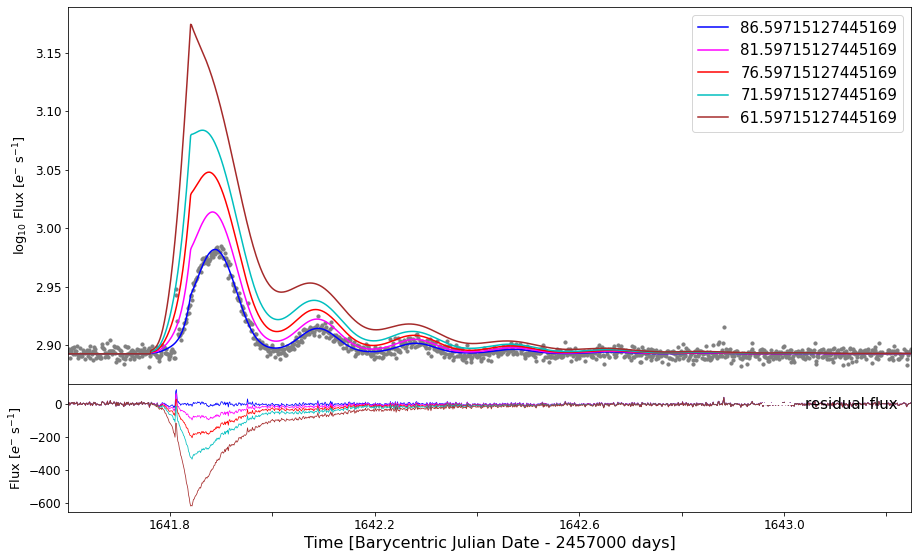

In [28]:
# Pick up stellar parameters
props = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
# Pick up the input parameters
mcmcinit = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")
# number of samples from the posterior distribution
N = 50

for ID, name, start, stop, tstamp, suffix in datasets:

    # Get MCMC data
    df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{tstamp}_{ID}{suffix}_converted_mcmc_sample.csv")

    # pick stellar parameters
    target = props[props.ID == int(ID)].iloc[0]
    
    
    inits = mcmcinit[(mcmcinit.ID.astype(str) == str(ID) + suffix) & (mcmcinit.tstamp==tstamp)].iloc[0]
    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg / u.cm**2 / u.s 
    R = inits.R_Rsun * R_sun

    # pick up light curve
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    median = lc.median_[0]
    
    # figures geometry: three panel of different size
    # from top to bottom: 
    # TOP: light curve and quiescent flux, rotation period
    # CENTER: flare-only light curve, model solution, underlying flare
    # BOTTOM: flare-model residuals, and uncertainties on flux
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13,8),sharex=True)
    divider = make_axes_locatable(ax)

#     ax = divider.append_axes("bottom", size="100%", pad=0)
#     ax3.figure.add_axes(ax)

    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax.figure.add_axes(ax2)

    # CENTER: flare-only light curve
    ax.scatter(time, np.log10(flux), s=10, c="grey")
    
    # plot N random solutions from the posterior distribution
    inds = np.random.randint(df.shape[0], size=1)
    for ind in inds:
        for afactor, sigma, color in [(-np.pi/180*30,0, "blue"),
                                      (0,-5,"magenta"),
                                      (0,-10,"r"),
                                      (+np.pi/180*30,-15, "c"),
                                      (0,-25,"brown"),]:#[(-3.,"c"),(-1.8, "blue"), (0,"r"), (1.5,"blue"),(2.5,"c")]:
        # pick solution from MCMC chain
            sample = df.loc[ind,]

            # get flare parameters
            a = sample.a #* afactor
            Fth = Fth #* afactor
            flaret = 1e4 #* afactor
            phi_a = (sample.t0_d -lc.t[0]) / target.Prot_d * 2 * np.pi 
            theta_a = (sample.latitude_deg ) / 180 * np.pi 
            fwhm1 = sample.fwhm1_d  / target.Prot_d * 2 * np.pi
            fwhm2 = sample.fwhm2_d / target.Prot_d * 2 * np.pi

            # ... and also the updated inclination
            i = min(np.pi/2,(sample.i_deg + sigma)/ 180 * np.pi )
#            print(i/np.pi*2, sample.i_deg)

            # convert flare peak phase to phase at t0
            phi0 = phi_a%(2.*np.pi) - (sample.phase_deg  / 180 * np.pi) #+ afactor

            # CENTER: plot the underlying best-fit flare
            flareparams =  [[a, phi_a, fwhm1, fwhm2]]
    #         print(flareparams)

            FM = FlareModulator(phi, flux, lc.flux_err.values, qlum, R, median, 1, False,flaret=flaret)

    #         flare = FM.flare_template([a*median, phi_a, fwhm1, fwhm2]) + median
    #         ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)

            # CENTER: plot the modulated best-fit flare
            fullmodel = FM.modulated_flux(theta_a, phi0, i,flareparams)
     #       phi_a, theta_a, a, fwhm1, fwhm2, i, phi0=phi0,
      #                             phi=phi, num_pts=50, qlum=qlum,
       #                            Fth=Fth, R=R, median=median)
            ax.plot(time, np.log10(fullmodel) , c=color, alpha=1, label=sample.i_deg + sigma)#0.05)

            # BOTTOM: plot the residuals
            ax2.plot(time, flux - fullmodel,c=color, alpha=1,#.05, #yerr=lc.flux_err,
                         #errorevery=5,  ecolor="r", 
                        # capsize=1, 
                      linewidth=.75)
 

    # Fetch the full original light curve
#     flck = fetch_lightcurve(target)

    # TOP: plot un-detrended light curve 
#     ax3.scatter(flck.time, np.log10(flck.flux), c="k", s=10)
    
    # TOP: plot quiescent flux model
#     ax3.plot(lc.t, np.log10(lc.modelflux), linewidth=3, c="orange")    
    
    # TOP LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    

#     legend_elements3 = [Line2D([0], [0], color='orange', lw=4, 
#                               label=f"{target.Prot_d*24.:.2f} h rotation period"),
#                        Line2D([0], [0], marker='o', color='w', 
#                               label=f"TIC {ID}",
#                               markerfacecolor='k', markersize=5),]
    
#     ax3.legend(handles=legend_elements3, fontsize=13, frameon=False, loc=1)

#     for label in ax3.xaxis.get_ticklabels():
#         label.set_visible(False)
        
    #------------------------------------------------------------------------------------------
    
    # BOTTOM LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    
    line = Line2D([],[], ls="none", c="r")
    barline = LineCollection(np.empty((2,2,2)), colors="r")
    err = ErrorbarContainer((line, [line], [barline]), has_yerr=True, label="uncertainty")
    legend_elements2 = [
                       Line2D([0], [0], color='w', lw=2, label="residual flux"),
                      # err,
                      ]
    ax2.legend(handles=legend_elements2, fontsize=15, frameon=False, loc=1)
    ax2.set_xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    
    #------------------------------------------------------------------------------------------

    
    # CENTER LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    legend_elements = [Line2D([0], [0], color='blue', lw=4, label="larger flaring region at ~50 deg latitude"),
                   Line2D([0], [0], color='r', lw=4, label="best-fit solution"),
                   Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                          markerfacecolor='grey', markersize=5),]

    ax.legend()#handles=legend_elements, fontsize=15, frameon=False)
    
    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)

    #------------------------------------------------------------------------------------------
        
        
    # Y-Labels
    # ------------------------------------------------------------------------    

    ax.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
#     ax3.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax2.set_ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ------------------------------------------------------------------------    

    
    # remaining layout
    for axis in [ax, ax2]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        
    plt.tight_layout()
    
#     ax.set_ylim(2.88,2.92)
    
    # Save to file
    
#     plt.savefig(f"{CWD}/analysis/plots/flarefit/review/"
#                 f"{tstamp}_{target.prefix}{target.ID}_decoupled_{name}_+.4_a_-20deg_theta_x2_fwhm1.png",
#                 dpi=300)

In [ ]:
(1 - np.cos(28/180*np.pi)) * 2

# Double-flare solution decoupled

In [2]:
# Datasets we analysed
 datasets = [
            (237880881,"normal_uncertainties",
             1331.6,1332.6, 
            "07_12_2020_07_47",),
            (237880881,"high_uncertainties_peaks12",
             1331.6,1332.6,
             "10_12_2020_07_11"),
            (44984200, "normal_uncertainties",  
            1587.8,1588.7, 
            "07_12_2020_19_42"),
            (44984200,"high_uncertainties_peaks12",
               1587.8,1588.8,
              "10_12_2020_07_10")
            ]

In [3]:
result = pd.read_csv("../results/mcmc/15_12_2020_GP_mcmcoutput.csv")
result.ID, result.suffix

(0    452922110
 1    277539431
 2    237880881
 3    237880881
 4     44984200
 5     44984200
 Name: ID, dtype: int64,
 0    NaN
 1    NaN
 2      a
 3      b
 4      a
 5      b
 Name: suffix, dtype: object)

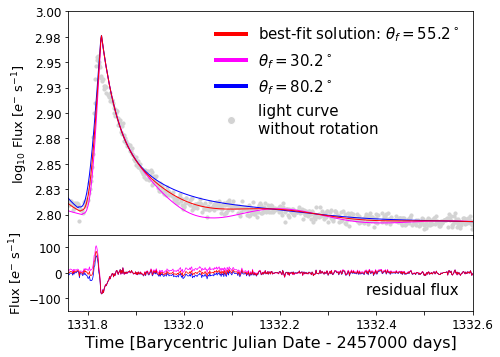

In [8]:
%matplotlib inline
# Pick up stellar parameters
props = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
# Pick up the input parameters
mcmcinit = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")
# number of samples from the posterior distribution
N = 50

for ID, name, start, stop, tstamp in datasets[1:2]:

    # pick up light curve
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    time = lc.t
    phi = lc.phi.values 
    flux = lc.flux.values
    median = lc.median_[0]
    
    # pick up stellar parameters
    target = props[props.ID == int(ID)].iloc[0]
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5), sharex=True)
    divider = make_axes_locatable(ax)


    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax.figure.add_axes(ax2)

    # CENTER: flare-only light curve
    ax.scatter(time, np.log10(flux), s=10, c="lightgrey")
    
    #--------------------------------------------------------------
 
    # plot a number of random solutions from the posterior distribution
#     inds = np.random.randint(dfa.shape[0], size=N)

    # start with the median and add both flares on top

    for color, sigma, af, fwhmf in [("magenta", -25, 1.335, .9),
                                    ("blue", 25, .94, 1.1),("r",0,1,1),]:
#                                   ("blue", 20, .94, 1.1),("blue", 15, .94, 1.1),("blue", 30, .94, 1.1),]:
        flare = np.full(len(phi), median,)
        fullmodel = np.full(len(phi), median)

        # do one flare at a time
        for suffix in ["a","b"]:


            # get stellar parameters
            inits_ = mcmcinit[(mcmcinit.ID == str(ID)+suffix) & (mcmcinit.tstamp==tstamp)].iloc[0]
            sample = result[(result.ID == int(ID)) & (result.suffix==suffix)].iloc[0]
            qlum = inits_.qlum_erg_s * u.erg / u.s
            Fth = inits_.Fth * u.erg / u.cm**2 / u.s
            R = inits_.R_Rsun * R_sun

            # get flare parameters
#                 df = ddic[suffix]
#                 sample = df.loc[ind,]
            a = sample.a_50 * af

            phi_a = (sample.t0_d_50 - lc.t[0]) / target.Prot_d * 2 * np.pi 
            theta_a = (sample.latitude_deg_50 +sigma)/ 180 * np.pi
            #prot = target.Prot_d * 1.01

            fwhm1 = sample.fwhm1_d_50 /  target.Prot_d * 2 * np.pi * fwhmf
            fwhm2 = sample.fwhm2_d_50 /  target.Prot_d * 2 * np.pi 

#             phi = (phi-phi[0]) target.Prot_d + phi[0] 
            # ... and inclination
            i = sample.i_deg_50 / 180 * np.pi

            # both phase_degs map to the same phi0 at t0
            if suffix=="a":
                phi0 = phi_a%(2.*np.pi) - (sample.phase_deg_50  / 180 * np.pi)

            flareparams =  [[a, phi_a, fwhm1, fwhm2]]

            FM = FlareModulator(phi, flux, lc.flux_err.values, qlum, R, median, 1, False,flaret=1e4)

            fullmodel = FM.modulated_flux(theta_a, phi0, i,flareparams) + fullmodel

        # CENETER: underlying and modeled flares
      #  ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel-2*median) , c=color, linewidth=1)

        # BOTTOM: residuals
        ax2.plot(time, flux-fullmodel+2*median,#yerr=lc.flux_err,errorevery=5,ecolor="r", capsize=1,
                       c=color,linewidth=.75)



    # CENTER LEGEND and LAYOUTl
    #------------------------------------------------------------------------------------------
    legend_elements = [Line2D([0], [0], color='r', lw=4, label=r"best-fit solution: $\theta_f=55.2^\circ$"),
                       Line2D([0], [0], color='magenta', lw=4, label=r"$\theta_f=30.2^\circ$"),
                       Line2D([0], [0], color='blue', lw=4, label=r"$\theta_f=80.2^\circ$"),
                       Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                          markerfacecolor='lightgrey', markersize=8),]

    ax.legend(handles=legend_elements, fontsize=15, frameon=False)
    
    
    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)
    #-------------------------------------------------------------------------
    
        
    # BOTTOM LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    
    line = Line2D([],[], ls="none", c="r")
    barline = LineCollection(np.empty((2,2,2)), colors="r")
   # err = ErrorbarContainer((line, [line], [barline]), has_yerr=True, label="uncertainty")
    legend_elements2 = [Line2D([0], [0], color='w', lw=1, label="residual flux"),
                        ]
    ax2.legend(handles=legend_elements2, fontsize=15, frameon=False, loc=4)
    
    ax2.set_xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    #------------------------------------------------------------------------------------------



    # Y-Labels
    # ------------------------------------------------------------------------

    ax.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
#     ax3.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax2.set_ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #-------------------------------------------------------------------------
    
    
    # Rest of the layout
    # ------------------------------------------------------------------------

    for axis in [ax, ax2]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        axis.set_xlim(1331.76, stop)
    plt.tight_layout()
    ax.set_ylim(2.78,3.)
    ax2.set_ylim(-150,150)
    plt.savefig(f"{CWD}/analysis/plots/flarefit/review/"
                f"237_latitude_variation.png",
                dpi=300)

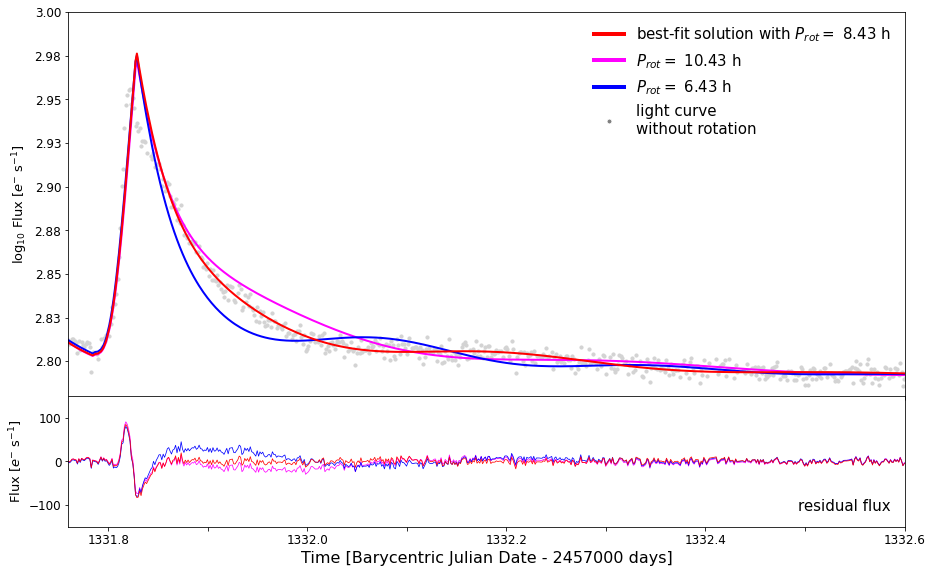

In [120]:
%matplotlib inline
# Pick up stellar parameters
props = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
# Pick up the input parameters
mcmcinit = pd.read_csv(f"{CWD}/data/summary/inits_decoupled_GP.csv")
# number of samples from the posterior distribution
N = 50

for ID, name, start, stop, tstamp in datasets[1:2]:

    # pick up light curve
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    time = lc.t
    phi = lc.phi.values 
    flux = lc.flux.values
    median = lc.median_[0]
    
    # pick up stellar parameters
    target = props[props.ID == int(ID)].iloc[0]
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,8), sharex=True)
    divider = make_axes_locatable(ax)


    ax2 = divider.append_axes("bottom", size="34%", pad=0)
    ax.figure.add_axes(ax2)

    # CENTER: flare-only light curve
    ax.scatter(time, np.log10(flux), s=10, c="lightgrey")
    
    #--------------------------------------------------------------
 

    # start with the median and add both flares on top

    for color, rotvar, af, fwhmf in [("magenta", (target.Prot_d + 1/12) / target.Prot_d, 1.1,1),
                                     ("blue", (target.Prot_d - 1/12) / target.Prot_d, .925,1),
                                     ("r",1,1,1)]:
        prot = target.Prot_d * rotvar
        phi = lc.phi.values 
        phi = (phi-phi[0]) /rotvar + phi[0] 
        flare = np.full(len(phi), median,)
        fullmodel = np.full(len(phi), median)

        # do one flare at a time
        for suffix in ["a","b"]:


            # get stellar parameters
            inits_ = mcmcinit[(mcmcinit.ID == str(ID)+suffix) & (mcmcinit.tstamp==tstamp)].iloc[0]
            sample = result[(result.ID == int(ID)) & (result.suffix==suffix)].iloc[0]
            qlum = inits_.qlum_erg_s * u.erg / u.s
            Fth = inits_.Fth * u.erg / u.cm**2 / u.s
            R = inits_.R_Rsun * R_sun

            a = sample.a_50  * af
            
            phi_a = (sample.t0_d_50 - lc.t[0]) / prot * 2 * np.pi
            dfphia = phi_a - (sample.t0_d_50 - lc.t[0]) / prot  * 2 * np.pi 
            theta_a = sample.latitude_deg_50 / 180 * np.pi
            

            fwhm1 = sample.fwhm1_d_50 / prot * 2 * np.pi 
            fwhm2 = sample.fwhm2_d_50 / prot * 2 * np.pi * fwhmf

#             
            # ... and inclination
            i = sample.i_deg_50 / 180 * np.pi

            # both phase_degs map to the same phi0 at t0
            if suffix=="a":
                phi0 = phi_a%(2.*np.pi) - (sample.phase_deg_50 / 180 * np.pi)

            flareparams =  [[a, phi_a, fwhm1, fwhm2]]

            FM = FlareModulator(phi, flux, lc.flux_err.values, qlum, R, median, 1, False,flaret=1e4)

            fullmodel = FM.modulated_flux(theta_a, phi0, i,flareparams) + fullmodel

        # CENETER: underlying and modeled flares
      #  ax.plot(time, np.log10(flare), c="grey", alpha=0.05, linewidth=3)
        ax.plot(time, np.log10(fullmodel-2*median) , c=color, linewidth=2)

        # BOTTOM: residuals
        ax2.plot(time, flux-fullmodel+2*median,#yerr=lc.flux_err,errorevery=5,ecolor="r", capsize=1,
                       c=color,linewidth=.75)



    # CENTER LEGEND and LAYOUTl
    #------------------------------------------------------------------------------------------
    legend_elements = [Line2D([0], [0], color='r', lw=4, 
                              label=r"best-fit solution with $P_{rot}=$ " + f"{target.Prot_d*24.:.2f} h"),
                       Line2D([0], [0], color='magenta', lw=4, 
                              label=r"$P_{rot}=$ " + f"{target.Prot_d *24 +2.:.2f} h"),
                       Line2D([0], [0], color='blue', lw=4, 
                              label=r"$P_{rot}=$ " + f"{target.Prot_d  *24 -2.:.2f} h"),
                       Line2D([0], [0], marker='o', color='w', label="light curve \nwithout rotation",
                          markerfacecolor='grey', markersize=5),]

    ax.legend(handles=legend_elements, fontsize=15, frameon=False)
    
    
    for label in ax.xaxis.get_ticklabels():
        label.set_visible(False)
    #-------------------------------------------------------------------------
    
        
    # BOTTOM LEGEND and LAYOUT
    #------------------------------------------------------------------------------------------
    
    line = Line2D([],[], ls="none", c="r")
    barline = LineCollection(np.empty((2,2,2)), colors="r")
   # err = ErrorbarContainer((line, [line], [barline]), has_yerr=True, label="uncertainty")
    legend_elements2 = [Line2D([0], [0], color='w', lw=1, label="residual flux"),
                        ]
    ax2.legend(handles=legend_elements2, fontsize=15, frameon=False, loc=4)
    
    ax2.set_xlabel(f"Time [Barycentric Julian Date - {target.BJDoff} days]",fontsize=16)
    
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    #------------------------------------------------------------------------------------------



    # Y-Labels
    # ------------------------------------------------------------------------

    ax.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
#     ax3.set_ylabel(r"$\log_{10}$ Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    ax2.set_ylabel(r"Flux [$e^{-}$ s$^{-1}$]",fontsize=13);
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #-------------------------------------------------------------------------
    
    
    # Rest of the layout
    # ------------------------------------------------------------------------

    for axis in [ax, ax2]:
        axis.set_xlim(lc.t.min(), lc.t.max())
        axis.set_xlim(1331.76, stop)
    plt.tight_layout()
    ax.set_ylim(2.78,3.)
    ax2.set_ylim(-150,150)
    plt.savefig(f"{CWD}/analysis/plots/flarefit/review"
                f"appendix_237_prot_variation.png",
                dpi=300)

In [33]:
65/180*np.pi

1.1344640137963142